In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Set some pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)


In [2]:
def load_json_file(filepath):
    """Load a single JSON file and return as DataFrame"""
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        if not data:  # If file is empty ([])
            return None
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Get all JSON files
json_files = glob.glob('data/heartRate_*.json')
print(f"Found {len(json_files)} JSON files")

# Load all files
dfs = []
for file in json_files:
    df = load_json_file(file)
    if df is not None and not df.empty:
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
print(f"\nTotal records: {len(df)}")


Found 243 JSON files

Total records: 2673620


In [3]:
# Data cleaning and feature extraction
def clean_and_process_data(df):
    # Convert datetime to pandas datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Sort by datetime
    df = df.sort_values('datetime')
    
    # Extract time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['date'] = df['datetime'].dt.date
    
    # Calculate time differences between measurements
    df['time_diff'] = df['datetime'].diff().dt.total_seconds()
    
    return df

# Clean the data
df_clean = clean_and_process_data(df)

# Basic statistics
print("Basic Statistics:")
print(df_clean['heart_rate'].describe())

# Check for missing values
print("\nMissing Values:")
print(df_clean.isnull().sum())


Basic Statistics:
count    2.673620e+06
mean     7.584011e+01
std      1.909862e+01
min      3.800000e+01
25%      6.200000e+01
50%      7.200000e+01
75%      8.500000e+01
max      2.000000e+02
Name: heart_rate, dtype: float64

Missing Values:
timestamp      0
datetime       0
heart_rate     0
hour           0
day_of_week    0
date           0
time_diff      1
dtype: int64


In [4]:
# Data quality checks
def print_data_quality_report(df):
    print("Data Quality Report")
    print("-" * 50)
    
    # Date range
    print(f"Date Range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"Total Days: {len(df['date'].unique())}")
    
    # Heart rate range check
    print(f"\nHeart Rate Range: {df['heart_rate'].min()} to {df['heart_rate'].max()} BPM")
    suspicious_hr = df[df['heart_rate'].between(40, 200) == False]
    if len(suspicious_hr) > 0:
        print(f"Suspicious heart rates (outside 40-200 BPM): {len(suspicious_hr)} records")
    
    # Time difference checks
    large_gaps = df[df['time_diff'] > 600]  # Gaps larger than 10 minutes
    if len(large_gaps) > 0:
        print(f"\nLarge time gaps (>10 min): {len(large_gaps)} instances")

print_data_quality_report(df_clean)


Data Quality Report
--------------------------------------------------
Date Range: 2024-11-12 00:05:15.422000+00:00 to 2025-07-08 01:59:59.100000+00:00
Total Days: 209

Heart Rate Range: 38 to 200 BPM
Suspicious heart rates (outside 40-200 BPM): 12 records

Large time gaps (>10 min): 11 instances


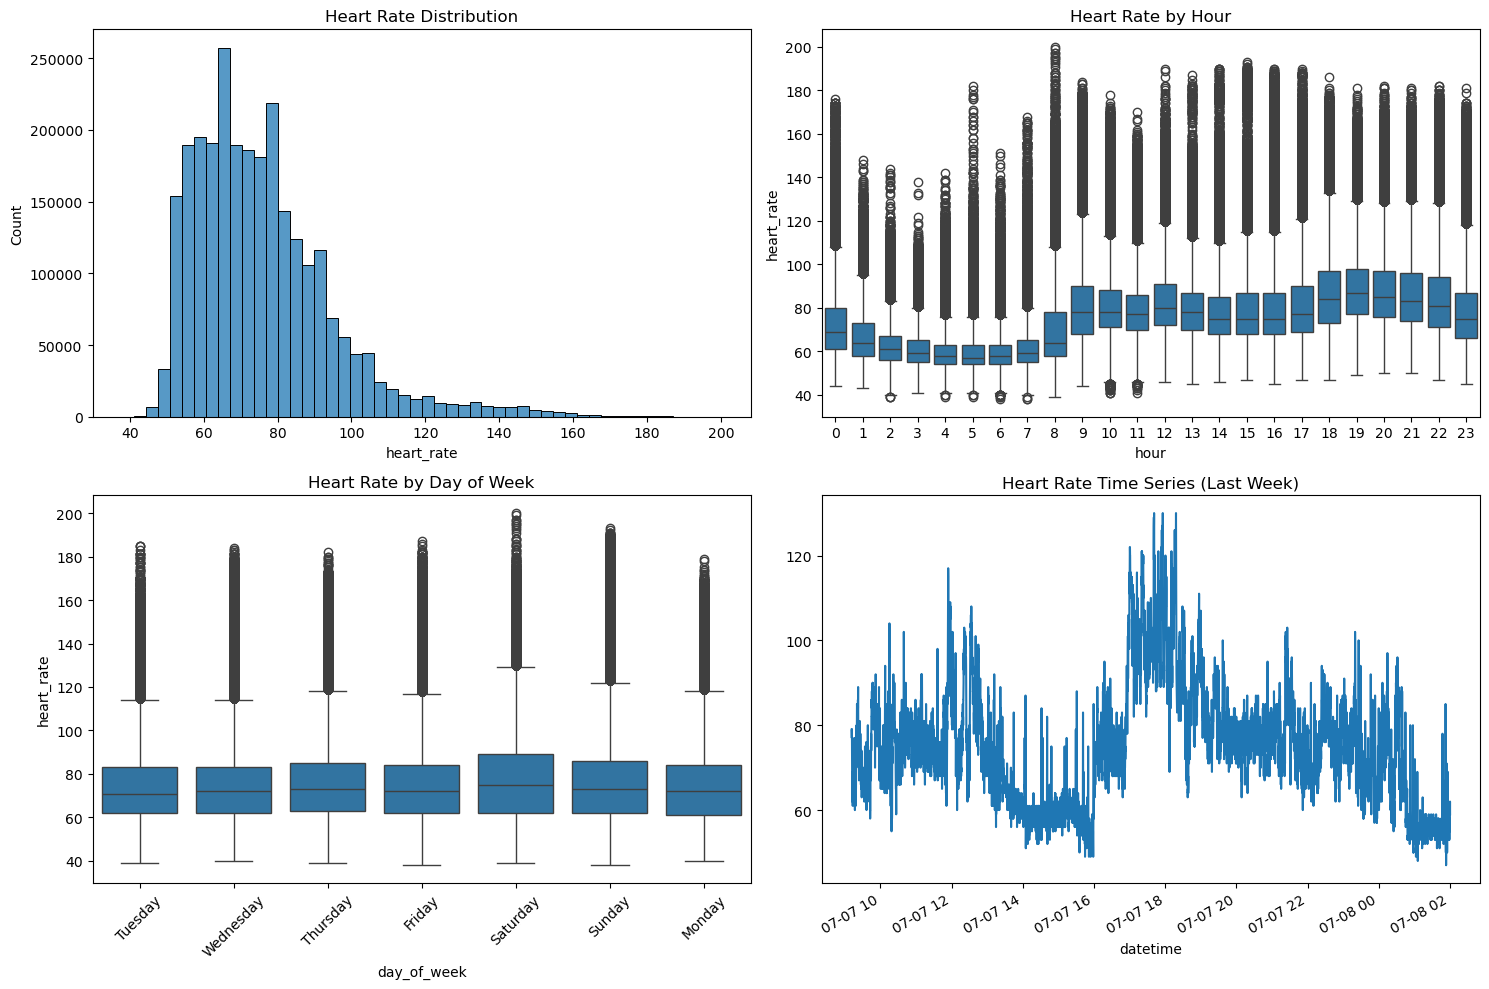

In [5]:
# Visualizations for data quality assessment
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Heart rate distribution
sns.histplot(data=df_clean, x='heart_rate', bins=50, ax=axes[0,0])
axes[0,0].set_title('Heart Rate Distribution')

# Heart rate by hour
sns.boxplot(data=df_clean, x='hour', y='heart_rate', ax=axes[0,1])
axes[0,1].set_title('Heart Rate by Hour')

# Heart rate by day of week
sns.boxplot(data=df_clean, x='day_of_week', y='heart_rate', ax=axes[1,0])
axes[1,0].set_title('Heart Rate by Day of Week')
axes[1,0].tick_params(axis='x', rotation=45)

# Time series plot of one week
one_week = df_clean.set_index('datetime').iloc[-10080:]['heart_rate']  # Last week of data (assuming 6 measurements per minute)
one_week.plot(ax=axes[1,1])
axes[1,1].set_title('Heart Rate Time Series (Last Week)')

plt.tight_layout()
plt.show()


In [6]:
# Calculate some useful aggregations
# Daily statistics
daily_stats = df_clean.groupby('date').agg({
    'heart_rate': ['mean', 'min', 'max', 'std', 'count']
}).round(2)

daily_stats.columns = ['mean_hr', 'min_hr', 'max_hr', 'std_hr', 'measurements']
daily_stats = daily_stats.reset_index()

print("Daily Statistics Sample:")
print(daily_stats.head())

# Save processed data
df_clean.to_parquet('processed_heart_rate_data.parquet')
daily_stats.to_parquet('daily_heart_rate_stats.parquet')

print("\nData saved to:")
print("- processed_heart_rate_data.parquet (full dataset)")
print("- daily_heart_rate_stats.parquet (daily aggregations)")


Daily Statistics Sample:
         date  mean_hr  min_hr  max_hr  std_hr  measurements
0  2024-11-12    72.47      48     144   11.74         12794
1  2024-11-13    72.37      44     144   14.17         12840
2  2024-11-14    78.30      51     167   12.61         12840
3  2024-11-15    76.34      50     141   10.76         12835
4  2024-11-16    74.95      45     147   15.87         12840

Data saved to:
- processed_heart_rate_data.parquet (full dataset)
- daily_heart_rate_stats.parquet (daily aggregations)
